In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
import scipy.sparse as sparse

from tqdm import trange, tqdm

from collections import defaultdict, Counter
from itertools import combinations

import sys
sys.path.append('../')
from CAS import *

In [2]:
def read_snap(edge_file, com_file, prefix=""):
    edges = pd.read_csv(prefix+edge_file, sep='\t', comment="#")
    coms = []
    with open(prefix+com_file, "r") as infile:
        for line in infile:
            x = line[:-1]  # drop trailing newline
            x = x.split('\t')
            coms.append(frozenset([int(y) for y in x])) ## map to 0-based

    g = ig.Graph.DataFrame(edges, directed=False)

    c = [set() for _ in range(g.vcount())]
    for i, com in enumerate(coms):
        for v in com:
            c[v].add(i)
    c = [frozenset(i) for i in c] 
    g.vs["comms"] = c
    g.vs['n_comms'] = [len(x) for x in g.vs['comms']]
    # Vertex list is not continugous, drop degree 0 vertices
    g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  

    # Drop some vars to free up memory
    del edges

    return g, g.vs["comms"]


def read_abcdoo(edge_file, com_file, prefix=""):
    ## read edges, build graph
    fn = prefix+edge_file
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = prefix+com_file
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            coms = [int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]  # map to 0-based
            try:
                coms.remove(0)  # Community 0 is outliers
            except ValueError:
                pass
            L.append(tuple(coms)) 
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

In [3]:
## DBLP graph
dblp_g, dblp_coms = read_snap("com-dblp.ungraph.txt", "com-dblp.all.cmty.txt", "../../SNAP/")
abcdoo_d2_g = read_abcdoo("abcdoo_dblp_d2_edge.dat", "abcdoo_dblp_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d5_g = read_abcdoo("abcdoo_dblp_d5_edge.dat",  "abcdoo_dblp_d5_com.dat","../../ABCDGraphGenerator.jl/utils/")
abcdoo_d10_g = read_abcdoo("abcdoo_dblp_d10_edge.dat", "abcdoo_dblp_d10_com.dat", "../../ABCDGraphGenerator.jl/utils/")

print(f"DBLP has {dblp_g.vcount()} vertices.")
print(f"DBLP has {dblp_g.ecount()} edges.")

DBLP has 317080 vertices.
DBLP has 1049865 edges.


In [4]:
def get_nodes_in_i_coms(g, i):
    node_ids = np.arange(g.vcount())
    i_coms = np.array(dblp_g.vs["n_comms"]) == i
    return node_ids[i_coms]


def get_top_k_iefs(g, k):
    """
    Returns a (n,k) numpy array. One node per row, and the row is the top k ief scores sorted in descending order.
    """
    ## GT community membership matrix
    X = np.repeat(np.arange(g.vcount(), dtype=int), g.vs['n_comms'])
    Y = np.array([i for j in g.vs['comms'] for i in j])
    n = len(X)
    M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(g.vcount(), max(Y)+1) )
    A = g.get_adjacency_sparse()

    ## Compute CAS measures
    IEF, NIEF, _, _, _ = CAS(A, M, alpha=1)

    data = []
    for i in range(g.vcount()):
        n_comms = g.vs[i]["n_comms"]
        iefs = np.sort(IEF[i].toarray().reshape(-1)) # sorted in increasing
        for j in range(k):
            row = (i, n_comms, j+1, iefs[-(j+1)]) # row is (node_id, n_comms, rank, value)
            data.append(row)
    ief = pd.DataFrame(data, columns=["Node id", "N Comms", "IEF Rank", "IEF"])

    data = []
    for i in range(g.vcount()):
        n_comms = g.vs[i]["n_comms"]
        iefs = np.sort(NIEF[i].toarray().reshape(-1)) # sorted in increasing
        for j in range(k):
            row = (i, n_comms, j+1, iefs[-(j+1)]) # row is (node_id, n_comms, rank, value)
            data.append(row)
    nief = pd.DataFrame(data, columns=["Node id", "N Comms", "NIEF Rank", "NIEF"])

    return ief, nief

Text(0.5, 1.0, 'Top 5 IEF by Number of Communites in DBLP')

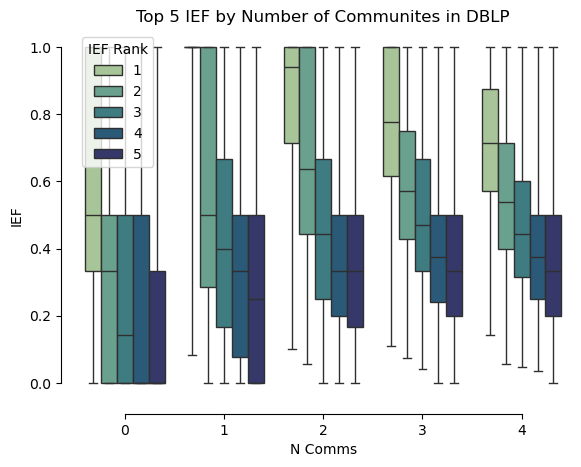

In [9]:
k = 5
g = dblp_g
name = "DBLP"
iefs, niefs = get_top_k_iefs(g, k)

sns.boxplot(x="N Comms", y="IEF",
            hue="IEF Rank", palette="crest",
            data=iefs[iefs["N Comms"] < 5],
            whis=(0, 100)
            )
sns.despine(offset=10, trim=True)
plt.title(f"Top {k} IEF by Number of Communites in {name}")

In [5]:
k = 5
g = abcdoo_d2_g
name = "ABCD+o^2 d=2"
iefs, niefs = get_top_k_iefs(g, k)

sns.boxplot(x="N Comms", y="IEF",
            hue="IEF Rank", palette="crest",
            data=iefs[iefs["N Comms"] < 5],
            whis=(0, 100)
            )
sns.despine(offset=10, trim=True)
plt.title(f"Top {k} IEF by Number of Communites in {name}")

Text(0.5, 1.0, 'Top 5 IEF by Number of Communites in ABCD+o^2 d=5')

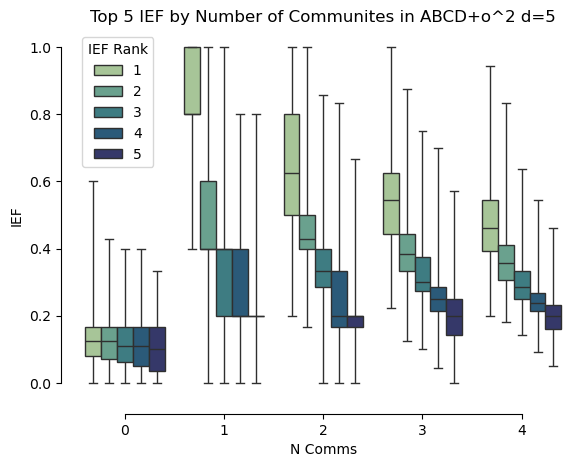

In [10]:
k = 5
g = abcdoo_d5_g
name = "ABCD+o^2 d=5"
iefs, niefs = get_top_k_iefs(g, k)

sns.boxplot(x="N Comms", y="IEF",
            hue="IEF Rank", palette="crest",
            data=iefs[iefs["N Comms"] < 5],
            whis=(0, 100)
            )
sns.despine(offset=10, trim=True)
plt.title(f"Top {k} IEF by Number of Communites in {name}")

Text(0.5, 1.0, 'Top 5 IEF by Number of Communites in ABCD+o^2 d=10')

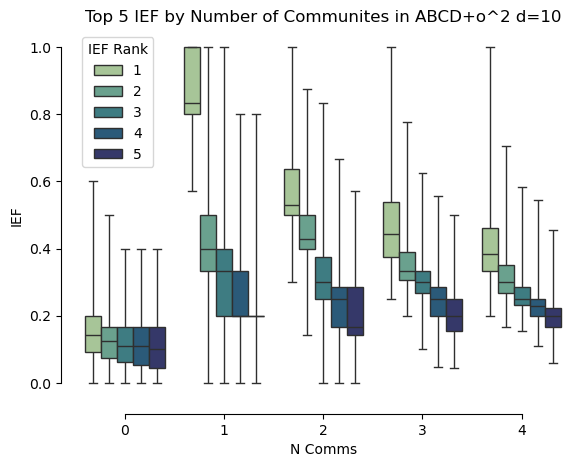

In [11]:
k = 5
g = abcdoo_d10_g
name = "ABCD+o^2 d=10"
iefs, niefs = get_top_k_iefs(g, k)

sns.boxplot(x="N Comms", y="IEF",
            hue="IEF Rank", palette="crest",
            data=iefs[iefs["N Comms"] < 5],
            whis=(0, 100)
            )
sns.despine(offset=10, trim=True)
plt.title(f"Top {k} IEF by Number of Communites in {name}")